<a href="https://colab.research.google.com/github/Zexsteel900/XAI-Comparative-Analysis-of-Post-Hoc-Methods/blob/main/XAI_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
pip install shap lime tensorflow keras matplotlib opencv-python

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap

In [29]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Convert grayscale images to RGB
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

In [30]:
# Build a simple CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), name='conv2d_1'),
    MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_1'),
    Flatten(name='flatten_1'),
    Dense(128, activation='relu', name='dense_2'),
    Dense(10, activation='softmax', name='dense_3')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_rgb, y_train, epochs=5, validation_split=0.1, verbose=2)

Epoch 1/5
1688/1688 - 6s - loss: 0.1385 - accuracy: 0.9582 - val_loss: 0.0582 - val_accuracy: 0.9830 - 6s/epoch - 4ms/step
Epoch 2/5
1688/1688 - 6s - loss: 0.0489 - accuracy: 0.9845 - val_loss: 0.0634 - val_accuracy: 0.9842 - 6s/epoch - 3ms/step
Epoch 3/5
1688/1688 - 9s - loss: 0.0317 - accuracy: 0.9902 - val_loss: 0.0510 - val_accuracy: 0.9882 - 9s/epoch - 5ms/step
Epoch 4/5
1688/1688 - 9s - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0680 - val_accuracy: 0.9820 - 9s/epoch - 5ms/step
Epoch 5/5
1688/1688 - 9s - loss: 0.0138 - accuracy: 0.9953 - val_loss: 0.0601 - val_accuracy: 0.9862 - 9s/epoch - 5ms/step


In [31]:
# Evaluate model
loss, accuracy = model.evaluate(X_test_rgb, y_test)
print(f"Test Accuracy: {accuracy}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0512 - accuracy: 0.9853
Test Accuracy: 0.9853000044822693


In [46]:
# Select a test image
test_images = [X_test_rgb[i] for i in [3, 8, 4, 5, 9]]
test_labels = [y_test[i] for i in [3, 8, 4, 5, 9]]

In [47]:
def generate_explanations(image):
    # LIME explanation
    explainer_lime = lime_image.LimeImageExplainer()
    explanation_lime = explainer_lime.explain_instance(
        image,
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    lime_img, mask = explanation_lime.get_image_and_mask(
        explanation_lime.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # SHAP explanation
    explainer_shap = shap.GradientExplainer(model, X_train_rgb[:100])
    shap_values = explainer_shap.shap_values(image[np.newaxis, ...])
    # Extract SHAP values for each class and normalize
    shap_values_np = np.array(shap_values)
    shap_values_normalized = [np.clip((val - np.min(val)) / (np.max(val) - np.min(val)), 0, 1) for val in shap_values_np]
    shap_img = np.mean(shap_values_normalized, axis=0).reshape(10,28,28,3)
    shap_img = shap_img.squeeze()

    # Grad-CAM explanation
    def grad_cam(input_model, image, layer_name):
        grad_model = tf.keras.models.Model(
            [input_model.inputs],
            [input_model.get_layer(layer_name).output, input_model.output]
        )
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(np.array([image]))
            loss = predictions[:, np.argmax(predictions[0])]
        output = conv_outputs[0]
        grads = tape.gradient(loss, conv_outputs)[0]
        guided_grads = tf.cast(output > 0, tf.float32) * tf.cast(grads > 0, tf.float32) * grads
        weights = tf.reduce_mean(guided_grads, axis=(0, 1))
        cam = np.zeros(output.shape[:2], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * output[:, :, i]
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()
        cam = np.uint8(cam * 255)
        cam = np.expand_dims(cam, axis=-1)
        cam = tf.image.resize(cam, (28, 28))
        return cam.numpy()

    grad_cam_img = grad_cam(model, image, 'conv2d_1')

    return lime_img, mask, shap_img, grad_cam_img


In [48]:
# Generate explanations for each test image
explanations = [generate_explanations(img) for img in test_images]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


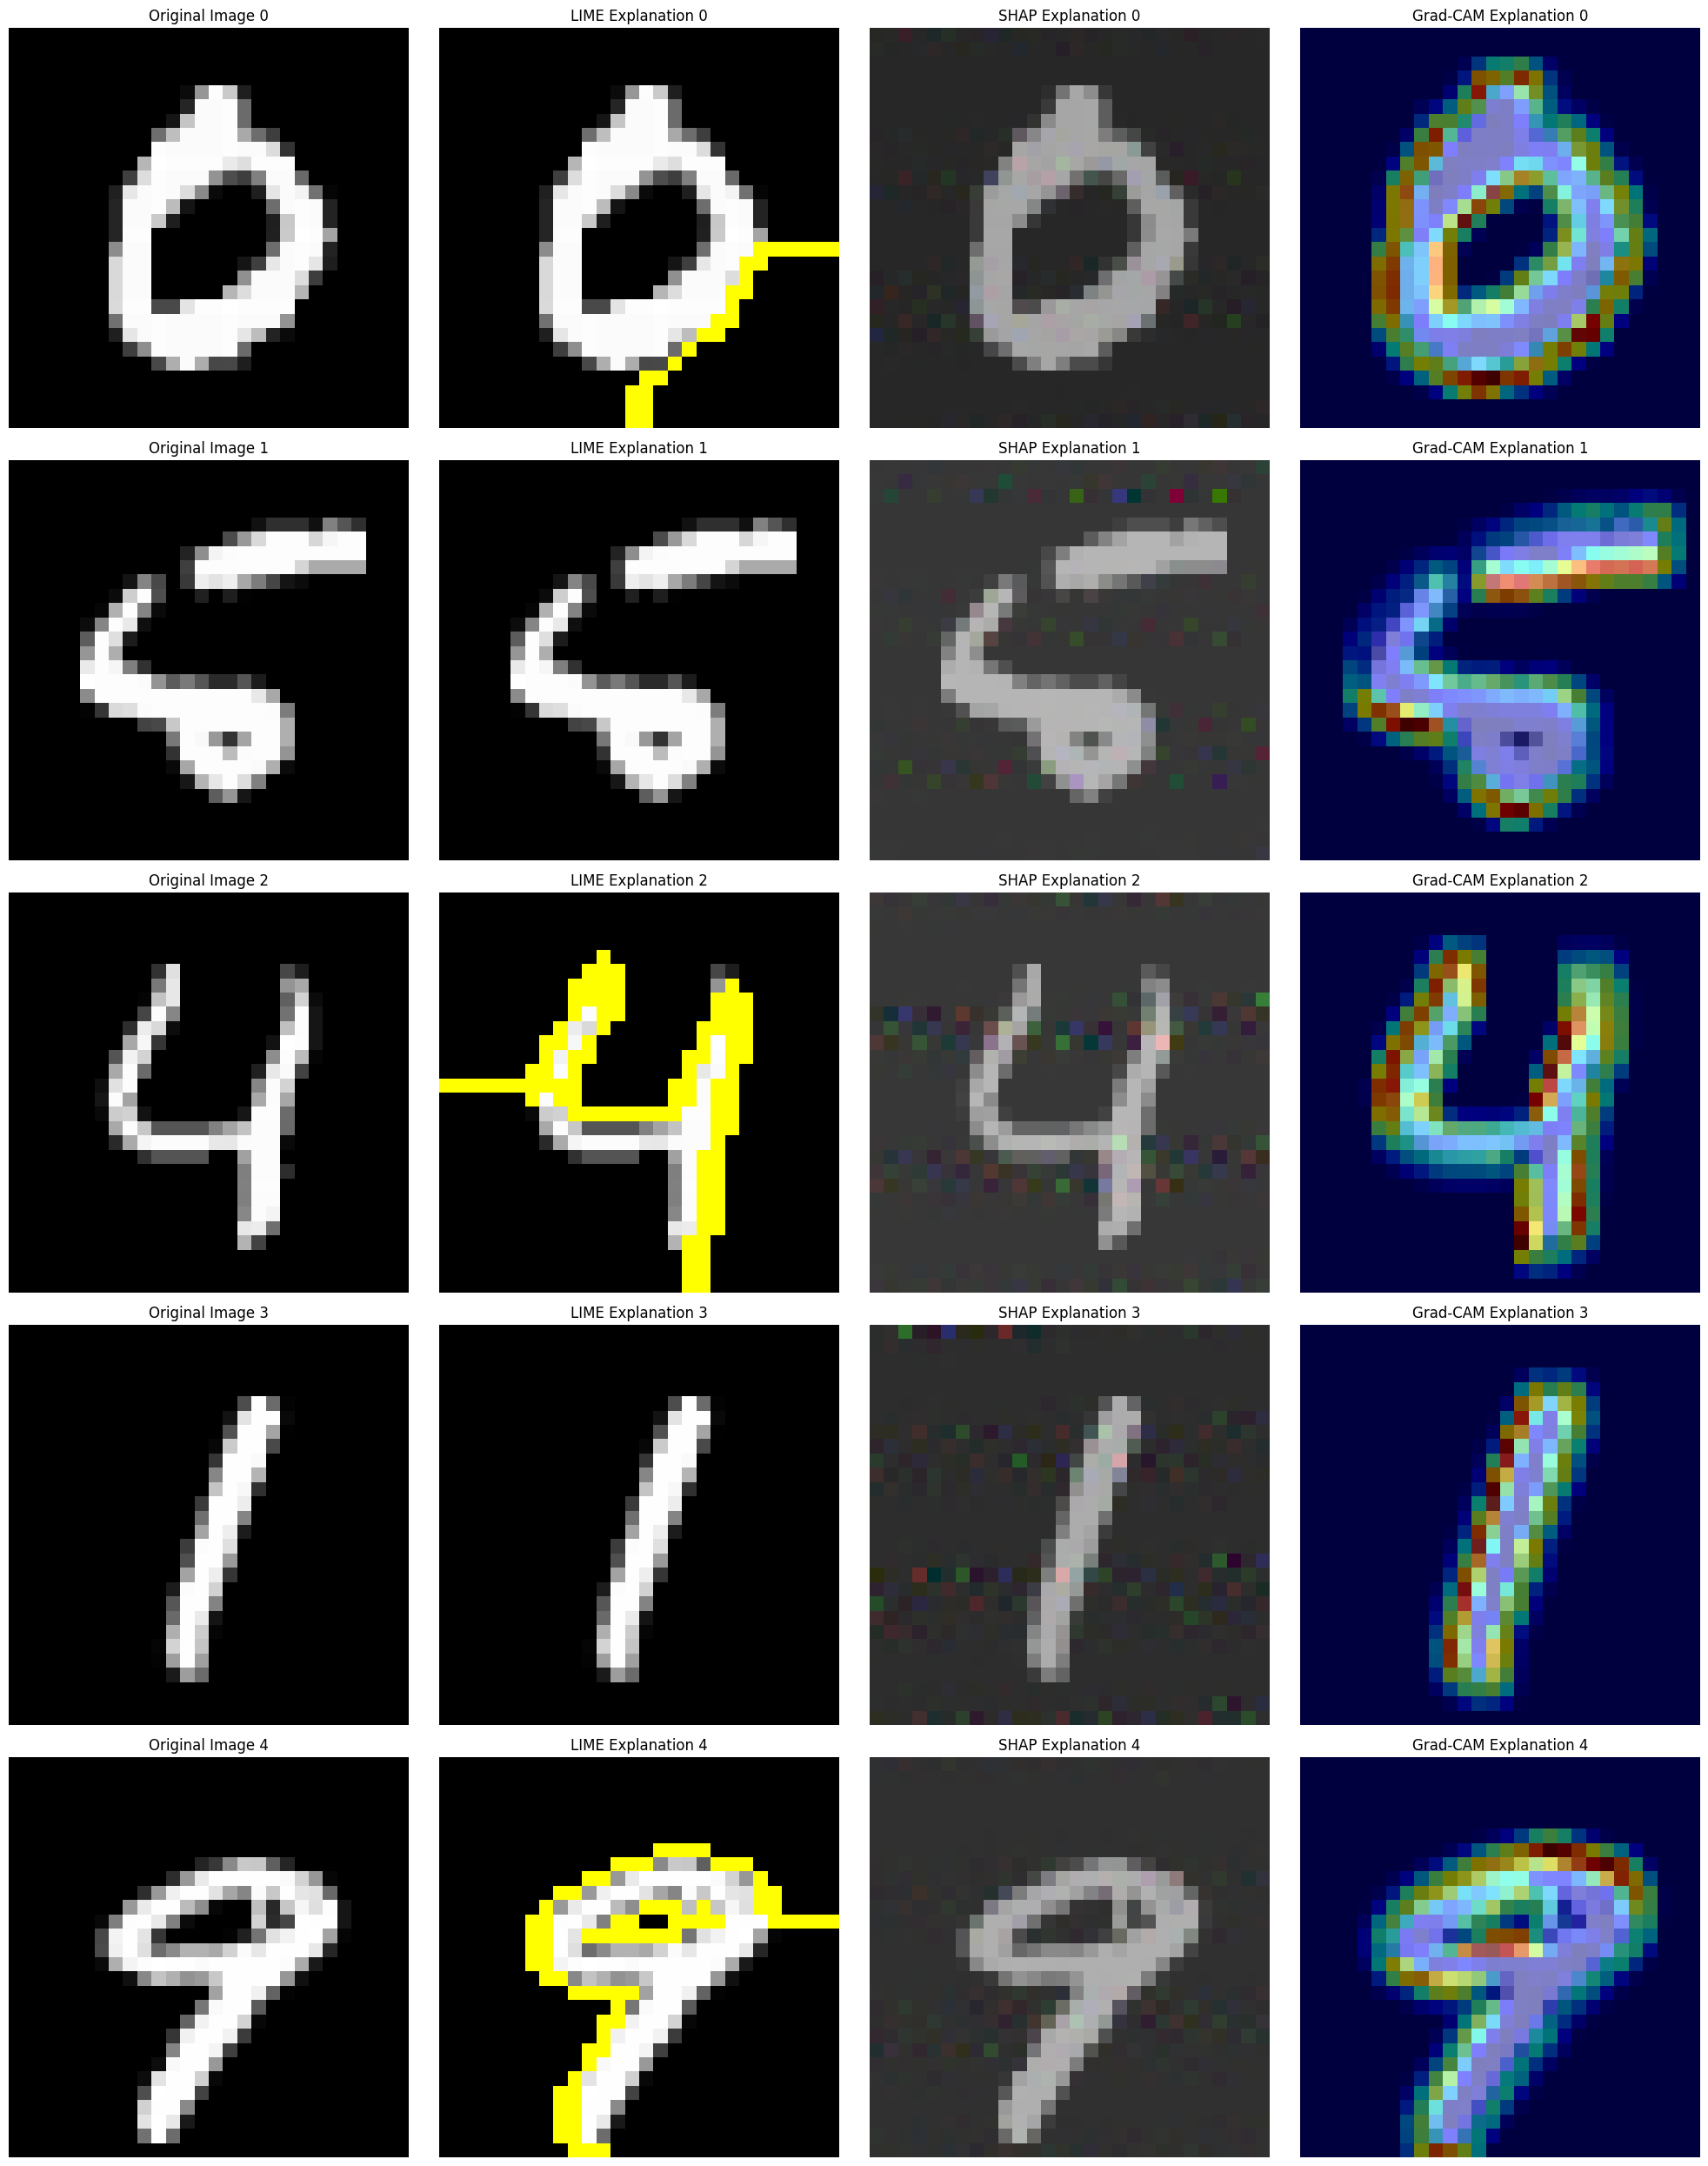

In [49]:
# Plot explanations
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
for i, (img, label) in enumerate(zip(test_images, test_labels)):
    lime_img, mask, shap_img, grad_cam_img = explanations[i]

    # Original image
    axes[i, 0].imshow(img.squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Original Image {i}")
    axes[i, 0].axis('off')

    # LIME
    axes[i, 1].imshow(mark_boundaries(img.squeeze(), mask))
    axes[i, 1].set_title(f"LIME Explanation {i}")
    axes[i, 1].axis('off')

    # SHAP
    axes[i, 2].imshow(img.squeeze(), cmap='gray')
    axes[i, 2].imshow(shap_img[2], cmap='jet', alpha=0.5)
    axes[i, 2].set_title(f"SHAP Explanation {i}")
    axes[i, 2].axis('off')

    # Grad-CAM
    axes[i, 3].imshow(img.squeeze(), cmap='gray')
    axes[i, 3].imshow(grad_cam_img.squeeze(), cmap='jet', alpha=0.5)
    axes[i, 3].set_title(f"Grad-CAM Explanation {i}")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()